In [3]:
import numpy as np
import matplotlib 
import matplotlib as mpl

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
from definitions import *

In [4]:
## define your image grid

x = np.arange(128)
xx, yy = np.meshgrid(x,x)

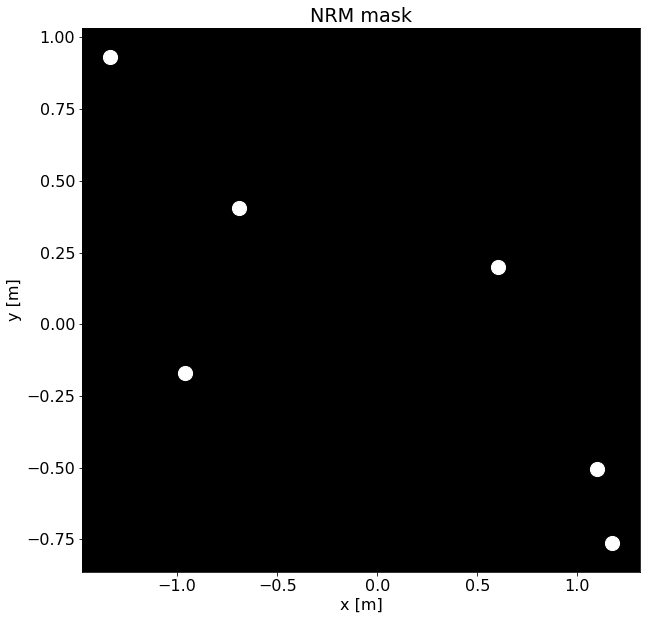

In [36]:
## define your interferometric array

coords = np.random.randn(6,2)
fig, ax = plt.subplots()
plt.scatter(coords[:,0],coords[:,1], color='white', s=200)
ax.set_facecolor("k")
plt.title("NRM mask")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
fig.savefig("mask.png")
np.savetxt('coords.txt',coords)

In [7]:
from ExoRIM.pysco.kpi import kpi

In [8]:
op = kpi(file='coords.txt',bsp_mat=None)

Creating from coordinate file
15 distinct baselines were identified
10 Kernel Phases identified.


In [9]:
bs = kpi(file='coords.txt',bsp_mat='sparse')

Creating from coordinate file
15 distinct baselines were identified
10 Kernel Phases identified.
Now calculating bispectrum
Calculating bispectrum matrix. Will take a few minutes.
Done 0 of 6 .  10  bispectra found. Time taken: 0.0 sec
Done. Total time taken: 0.0 mins
Found 20 bispectra
Doing sparse svd
Matrix rank: 10
Reduced-rank bispectrum matrix calculated.
Matrix shape (10, 15)
Time taken: 0.0 mins


In [10]:
bs.uv_to_bsp

array([[-0.52937994,  0.03451423, -0.29409293,  0.39086277,  0.05184327,
        -0.40232716,  0.12686868,  0.03352524, -0.02009399, -0.14892952,
         0.37855491,  0.08149541,  0.26013173,  0.18917662, -0.14676993],
       [ 0.19786878,  0.16482054,  0.34120495,  0.11112945, -0.06349486,
        -0.20267664,  0.09396887,  0.0395888 ,  0.14697996, -0.04201048,
         0.27176118, -0.23407896,  0.43377945, -0.63000231,  0.11100506],
       [ 0.19934783,  0.24520541,  0.12477664, -0.01120669, -0.56891753,
        -0.09620036, -0.10809162,  0.4646396 ,  0.02272871, -0.24914093,
        -0.08389776,  0.37503711,  0.08151468,  0.14451739, -0.29348789],
       [ 0.01415542, -0.34360692,  0.40095287,  0.17156852,  0.13892129,
         0.26414576,  0.29986652, -0.1440977 ,  0.25148347, -0.59148309,
         0.016184  , -0.00181783, -0.04957553,  0.12721887, -0.24448923],
       [-0.51231898,  0.40810262,  0.1602514 , -0.08504921, -0.02631684,
         0.10198505,  0.03899033,  0.23485842, 

Text(0, 0.5, 'v [m]')

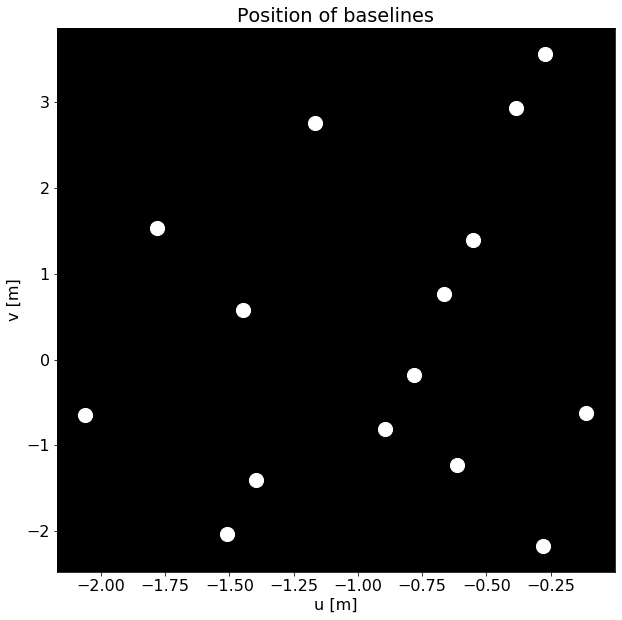

In [35]:
fig, ax = plt.subplots()
plt.scatter(bs.uv[:,0], bs.uv[:,1], color='white', s=200)
ax.set_facecolor("k")
plt.title(r"Position of baselines")
plt.xlabel("u [m]")
plt.ylabel("v [m]")

In [14]:
## create p2vm matrix

p2vm_sin = np.zeros((bs.uv.shape[0], xx.ravel().shape[0]))

for j in range(bs.uv.shape[0]):
    p2vm_sin[j,:] = np.ravel(np.sin(xx*bs.uv[j,0] + yy*bs.uv[j,1]))
    
p2vm_cos = np.zeros((bs.uv.shape[0], xx.ravel().shape[0]))

for j in range(bs.uv.shape[0]):
    p2vm_cos[j,:] = np.ravel(np.cos(xx*bs.uv[j,0] + yy*bs.uv[j,1]))



(15, 16384)

In [18]:
## define gaussian image - from halophot

def gaussian_psf(pixels,xp,yp,width):
    # make rr array
    npix = np.shape(pixels[0])[0]
    xx,yy = np.meshgrid(np.arange(npix)-npix/2.,np.arange(npix)-npix/2.)
    rr2 = (xx-xp)**2 + (yy-yp)**2
    
    return 1./(width*np.sqrt(2.*np.pi))*np.exp(-0.5*(rr2/width**2))

def normalize(vector):
    return (vector-vector.min())/(vector.max()-vector.min())

In [19]:
widths = [5,10,20,20]
xs = [20,-20,-50,90]
ys = [20,60,20,-60]
fs = [5,10,20,30]

In [20]:
image = np.zeros_like(xx)*1.
pixels = np.zeros_like(xx)
for j, w in enumerate(widths):
    image += fs[j]*gaussian_psf(pixels,xs[j]/2.,ys[j]/2.,w/2.)
    
image = normalize(image)
# image /= image.sum()

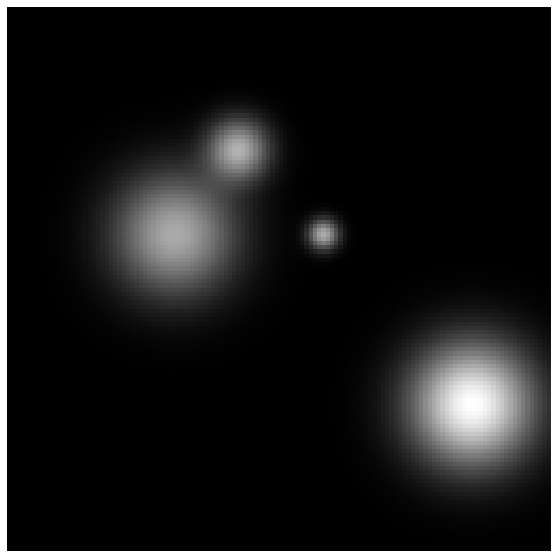

In [21]:

img = plt.imshow(image, cmap="gray")
plt.axis("off")
plt.savefig("image.png")

In [15]:
data_sin = np.dot(p2vm_sin,image.ravel())
data_cos = np.dot(p2vm_cos,image.ravel())
vis2s = np.abs(data_sin**2 + data_cos**2)
closure_phases = np.dot(bs.uv_to_bsp,np.angle(data_cos+1.j*data_sin))
recon = np.zeros_like(image)*1. # placeholder


In [27]:
closure_phases.shape

(10,)

### Now let's build the forwards model in TensorFlow

In [16]:
# create tensor to hold cosine and sine projection operators
T = tf.float64

# create tensor to hold cosine and sine projection operators
cos_tensor = tf.constant(p2vm_cos.T,dtype=T)
sin_tensor = tf.constant(p2vm_sin.T,dtype=T)
bs_tensor = tf.constant(bs.uv_to_bsp,dtype=T)


# create tensor to hold your data
vis2s_tensor = tf.constant(vis2s,dtype=T)
cp_tensor = tf.constant(closure_phases,dtype=T)
data_tensor = tf.concat([vis2s_tensor,cp_tensor],0)

# create tensor to hold your uncertainties
vis2s_err_tensor = tf.constant(np.ones_like(vis2s)*np.median(vis2s)/5.,dtype=T)
cp_err_tensor = tf.constant(np.ones_like(closure_phases)*np.median(closure_phases)/5.,dtype=T)
error_tensor = tf.concat([vis2s_err_tensor,cp_err_tensor],0)

# create tensor to hold your image model
image_tensor = tf.Variable(normalize(recon[:,:,np.newaxis])+1e-15,dtype=T)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [17]:
class Data_Generator(object):

    def __init__(self,train_batch_size=1,test_batch_size=1, impix_side = 192, im_size=128):
        self.im_size = im_size
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.impix_side = impix_side

    def gen_source(self):
        Im = np.ones((self.im_size,self.im_size))
        return Im

    def draw_im(self,train_or_test):
        if (train_or_test=="train"):
            np.random.seed(seed=None)
            num_samples = self.train_batch_size
        if (train_or_test=="test"):
            np.random.seed(seed=136)
            num_samples = self.test_batch_size
        
        self.IM_tr = np.zeros((num_samples,self.im_size,self.im_size))
        for i in range(num_samples):
            
            #parameters for im, here it's just an example  
            x = np.random.uniform(low=-1.0, high=1.)
            
            
            if (train_or_test=="train"):
                self.IM_tr[i,:,:] = self.gen_source()

            if (train_or_test=="test"):
                self.IM_ts[i,:,:] = self.gen_source()
 
        return

class Phys_Mod(object):

    def __init__(self, numpix_side = 192):
        self.numpix_side = numpix_side
                
    def physical_model(self, IM):
        
        sin_model = tf.tensordot(IM.ravel(), sin_tensor, axes=1)
        cos_model = tf.tensordot(IM.ravel(), cos_tensor, axes=1)
        vis2s = tf.abs(sin_model**2 + cos_model**2)  
        phases = tf.angle(tf.complex(data_cos,d ata_sin))
        cps = tf.tensordot(bs_tensor, phases,axes=1)
        return tf.concat([vis2s,cps],axis=0)

    def simulate_noisy_image(self, IM, noise = error_tensor):
        IM = self.physical_model(IM)
        noise = noise*tf.random_normal(tf.shape(IM),mean=0.0,stddev = 1.0,dtype=T)
        IM = IM + noise
        self.noise_rms = noise_rms
        return IM

    def log_likelihood(Data,Model,noise_rms):
        #logL = 0.5 * tf.reduce_mean(tf.reduce_mean((Data - Model)**2, axis=2 ), axis=1 )
        logL = 0.5 * tf.math.reduce_mean(tf.square(D - M), axis=1 )/ noise_sig**2
        return logL

In [18]:
train_batch_size = 4
num_steps = 10
num_features = 512
state_size = 128
im_size = recon.shape[0]
noise_rms = 0.01


In [19]:
IM_gen = Data_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,im_size=im_size)
Phys_Mod_obj = Phys_Mod()


In [20]:
physical_model = Phys_Mod_obj.physical_model

In [21]:
# test our tensorflow model is giving the same results on the input image
print(physical_model(image))
print(data_tensor)

tf.Tensor(
[ 1.44867752e-07  7.12594812e-08  1.01292470e-06  2.15376305e-02
  3.88387209e-08  4.54397316e-08  6.10408763e-05  7.11920873e-08
  1.05380334e-07  3.25081520e-07  4.75965983e+01  9.33808888e-04
  1.83080931e+01  1.79381206e-07  5.91894994e-04  1.47416144e+00
 -1.39761460e+00 -3.33211223e+00 -1.79560832e+00  2.58674911e+00
  9.08928807e-01  1.65737785e+00 -2.14917320e-01  2.69811559e-01
 -2.05851815e+00], shape=(25,), dtype=float64)
tf.Tensor(
[ 1.44867752e-07  7.12594812e-08  1.01292470e-06  2.15376305e-02
  3.88387209e-08  4.54397316e-08  6.10408763e-05  7.11920873e-08
  1.05380334e-07  3.25081520e-07  4.75965983e+01  9.33808888e-04
  1.83080931e+01  1.79381206e-07  5.91894994e-04  1.47416144e+00
 -1.39761460e+00 -3.33211223e+00 -1.79560832e+00  2.58674911e+00
  9.08928807e-01  1.65737785e+00 -2.14917320e-01  2.69811559e-01
 -2.05851815e+00], shape=(25,), dtype=float64)


### It gives the same results! Hurrah!

In [22]:
IM_gen.draw_im("train")


In [23]:
noisy_data = Phys_Mod_obj.simulate_noisy_image(IM,error_tensor)


NameError: name 'IM' is not defined